In [150]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [151]:
use_resid = False

if use_resid:
    # Load the residuals
    dataset_filename = '../datasets/power_transitions_with_residuals.xlsx'
else:
    dataset_filename = '../datasets/power_transitions.xlsx'

polity_df = download_data("https://seshatdata.com/api/core/polities/")
dataset = TSD(file_path=dataset_filename)
dataset.scv = dataset.scv.groupby('dataset').get_group('100y')
dataset.scv_imputed = dataset.scv_imputed.groupby('dataset').get_group('100y')

Downloaded 839 rows
Dataset loaded from ../datasets\power_transitions.xlsx


import Agri and AgriLag from TableData

In [152]:
import pyreadr

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)
df['PolityName'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'new_name'].values[0] if x in polity_df['name'].values else np.nan)
df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'id'].values[0] if x in polity_df['name'].values else np.nan)
df.drop_duplicates(subset=['PolityName', 'Year'], inplace=True)

df_old = df.copy()

In [153]:
if 'Agri' not in dataset.scv.columns:
    add_cols = ['Agri','AgriLag']
    for col in add_cols:
        dataset.scv[col] = np.nan
    # add cols to dataset by merging on PolityID and year from df_agri
    for n, row in df.iterrows():
        for col in add_cols:
            dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year']), col] = row[col]
            if len(dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year'])]) > 1:
                print(row['PolityName'], row['Year'])
                
    # fill in missing values for Agri and AgriLag when a polity has only some years missing
    for pol in dataset.scv.PolityName.unique(): 
        for col in add_cols:
            if dataset.scv.loc[dataset.scv['PolityName'] == pol, col].isna().any() and dataset.scv.loc[dataset.scv['PolityName'] == pol, col].notna().any():
                if col == 'Agri':
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(method='ffill')
                elif col == 'AgriLag':
                    # calculate change in year and add to agrilag value
                    agrilag = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), col].iloc[0]
                    year = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), 'Year'].iloc[0]
                    year_diff = year - dataset.scv.loc[(dataset.scv['PolityName'] == pol), 'Year']
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(agrilag - year_diff)

transfer_cols = ['Agri','AgriLag']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

plot new (imputed) data against Tabledata

         PolityName  Year   Pop_old   Pop_new      diff
667  mn_mongol_late  1400  6.415277  4.718803  1.696475
668  mn_mongol_late  1500  6.415277  4.718803  1.696475
195     eg_naqada_1 -3800  2.555193  4.113943  1.558750
848    in_deccan_nl -1900  2.514491  3.966640  1.452149
849    in_deccan_nl -1800  2.514491  3.966640  1.452149
850    in_deccan_nl -1700  2.514491  3.966640  1.452149
846    in_deccan_nl -2100  2.514491  3.966640  1.452149
845    in_deccan_nl -2200  2.514491  3.966640  1.452149
844    in_deccan_nl -2300  2.514491  3.966640  1.452149
843    in_deccan_nl -2400  2.514491  3.966640  1.452149
        PolityName  Year  Terr_old  Terr_new      diff
332    iq_ur_dyn_3 -2100  4.201310  5.762340  1.561030
62   fr_beaker_eba -2500  1.848933  3.207444  1.358512
57   fr_beaker_eba -3000  1.848933  3.207444  1.358512
61   fr_beaker_eba -2600  1.848933  3.207444  1.358512
60   fr_beaker_eba -2700  1.848933  3.207444  1.358512
59   fr_beaker_eba -2800  1.848933  3.207444  1.358512

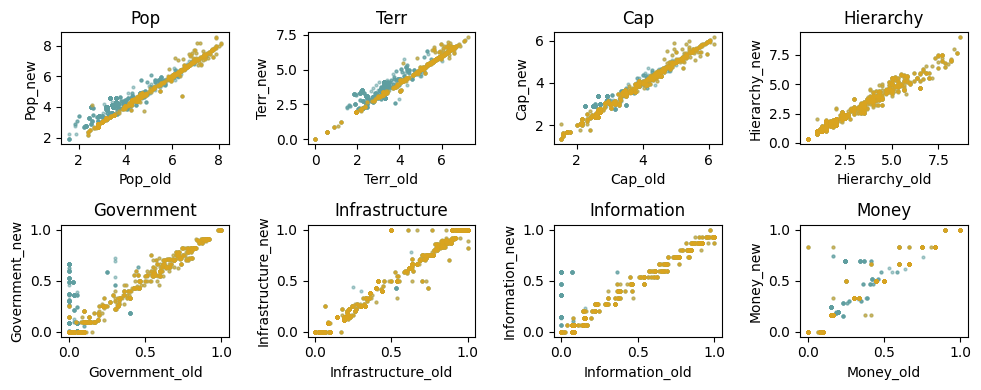

In [154]:
fig, ax = plt.subplots(2, 4, figsize=(10, 4))
ax = ax.flatten()
scale_cols = ['Pop','Terr','Cap']
non_scale_cols = ['Government','Infrastructure','Information','Money']
for c,col in enumerate(scale_cols+['Hierarchy']+non_scale_cols):
    df_merge = df[['PolityName','Year',col]].merge(dataset.scv_imputed[['PolityName','Year',col]], on=['PolityName','Year'], suffixes=('_old','_new'))
    df_merge['diff'] = df_merge[col+'_old'] - df_merge[col+'_new']
    df_merge['diff'] = df_merge['diff'].abs()
    df_merge = df_merge.sort_values('diff', ascending=False)
    print(df_merge.head(10))
    ax[c].plot(df_merge[col+'_old'], df_merge[col+'_new'], '.', color ="cadetblue", alpha=0.5, markersize = 4)
    df_merge = df[['PolityName','Year',col]].merge(dataset.scv[['PolityName','Year',col]], on=['PolityName','Year'], suffixes=('_old','_new'))
    ax[c].plot(df_merge[col+'_old'], df_merge[col+'_new'], '.', color ="goldenrod", alpha=0.5, markersize = 4)

    ax[c].set_ylabel(col+'_new')
    ax[c].set_xlabel(col+'_old')
    ax[c].set_title(col)
plt.tight_layout()
plt.show()

Extract next Scale and Comp values

In [92]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    
    # remove rows without a value 100 yrs later
    mask = (group['Year'].shift(-1) - group['Year'] != 100)
    indices = group.index.intersection(mask[mask].index)
    if len(indices) > 2:
        print(len(indices)-1)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan


2
2
2
3
6
3
2
3


Fit Scale

In [121]:
x_cols = ['Scale_1','Scale_sq','Agri','IronCav',"Miltech", 'Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Comp'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     3000.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:42:14   Log-Likelihood:                -474.95
No. Observations:                1158   AIC:                             961.9
Df Residuals:                    1152   BIC:                             992.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.0517      0.054     19.522      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1271338704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Comp'], inplace=True)


In [122]:
def analyze_residuals(values, residuals, bins):
    """
    Analyze residuals by binning comp values and calculating statistics
    
    Args:
        comp_values (array-like): Competitiveness values
        residuals (array-like): Model residuals
        bin_size (float): Size of bins (default 0.1)
    
    Returns:
        pandas.DataFrame with columns: Value, mean, SE, n, lower, upper
    """
    import pandas as pd
    import numpy as np

    bin_size = bins[1] - bins[0]
    # Initialize results
    results = []
    
    # Calculate stats for each bin
    for bin_center in bins[:-1]:
        mask = ((values >= bin_center - bin_size) & 
                (values < bin_center + bin_size))
        bin_residuals = residuals[mask]
        
        if len(bin_residuals) > 0:
            mean = np.mean(bin_residuals)
            se = np.std(bin_residuals)/np.sqrt(len(bin_residuals))
            results.append({
                'Value': bin_center + bin_size/2,
                'mean': mean,
                'SE': se,
                'n': len(bin_residuals),
                'lower': mean - se,
                'upper': mean + se
            })
    
    # Convert to dataframe
    df = pd.DataFrame(results)
    return df

In [132]:
import json
from pandas import json_normalize
data = json.load(open('../datasets/power_transitions.json'))

json_normalize(data[6])

variable_set            section subsection     variable_name  \
0     Crisisdb  Power Transitions       None  Power Transition   

                   polity_name polity_new_ID polity_old_ID  year_from  \
0  Egypt - Classic Old Kingdom    eg_old_k_1       EgOldK1      -2589   

   year_to confidence  ... coded_values.successor coded_values.contested  \
0    -2566  Confident  ...    Djedefre / Redjedef                     SU   

   coded_values.overturn coded_values.predecessor_assassination  \
0                      A                                      A   

  coded_values.intra_elite coded_values.military_revolt  \
0                        A                            A   

  coded_values.popular_uprising coded_values.separatist_rebellion  \
0                             A                                 A   

  coded_values.external_invasion coded_values.external_interference  
0                              A                                  A  

[1 rows x 25 columns]

Text(0, 0.5, 'Scale')

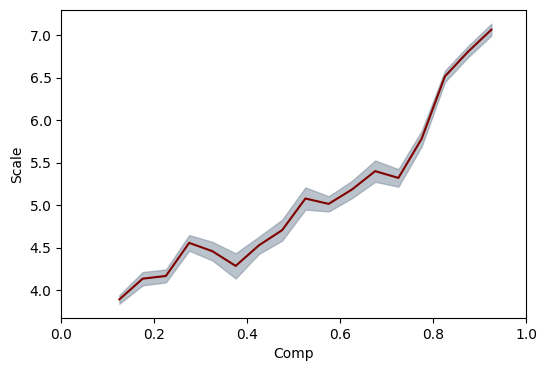

In [124]:
bins = np.arange(0.1, 1, 0.05)
results = analyze_residuals(Xy['Comp'].values, Xy['Scale_t'].values, bins)

plt.figure(figsize=(6, 4))
# plt.scatter(Xy['Comp'].values, Xy['Scale_1'].values, color='k', alpha=0.2, label='Predictions', s=3)

plt.plot(results['Value'], results['mean'], color='maroon')
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)

plt.xlim(.0, 1)
plt.xlabel("Comp")
plt.ylabel("Scale")

(0.0, 0.95)

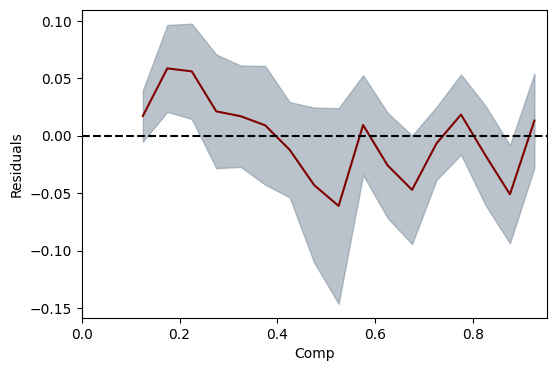

In [120]:
residuals = y['d_Scale'] - predictions.values
comp_values = Xy['Comp'].values
bins = np.arange(0.1, 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)
results_before = results.copy() 
residuals_before = residuals.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
x = np.linspace (-2,12,100)
# plt.scatter(Xy['Comp'], residuals, color='k', alpha=0.2, label='Predictions', s=3)

plt.xlim(0.0, 0.95)

In [76]:
thresh_start = np.arange(0.1, 0.9 , 0.02)
thresh_end = np.arange(0.2, 0.9, 0.01)
# x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','Miltech','IronCav','Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p', 'log-likelyhood','minres',"comp_pval"])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp >= thresh_s)&(Xy.Comp <= thresh_e)
        X['Comp'] = 0
        X.loc[mask, 'Comp'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Scale_t'].values - predictions)),
            'comp_pval': model.pvalues['Comp']
        }, ignore_index=True)



C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1031070540.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1031070540.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1031070540.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Loc

In [77]:
results.sort_values('comp_pval', ascending=True)

thresh_start  thresh_end       n        R2    R2_adj         AIC    p  \
2150          0.70        0.70  1158.0  0.928782  0.928473  960.348688  0.0   
1221          0.44        0.51  1158.0  0.928768  0.928458  960.585290  0.0   
1291          0.46        0.51  1158.0  0.928768  0.928458  960.585290  0.0   
213           0.16        0.23  1158.0  0.928685  0.928375  961.933799  0.0   
1361          0.48        0.51  1158.0  0.928673  0.928363  962.126222  0.0   
...            ...         ...     ...       ...       ...         ...  ...   
2794          0.88        0.84  1158.0  0.928262  0.928014  966.768084  0.0   
2795          0.88        0.85  1158.0  0.928262  0.928014  966.768084  0.0   
2796          0.88        0.86  1158.0  0.928262  0.928014  966.768084  0.0   
2797          0.88        0.87  1158.0  0.928262  0.928014  966.768084  0.0   
2798          0.88        0.88  1158.0  0.928262  0.928014  966.768084  0.0   

      log-likelyhood    minres  comp_pval  
2150     -474.174344  0.183460   0.003810  
1221     -474.292645  0.185540   0.004337  
1291     -474.292645  0.185540   0.004337  
213      -474.966900  0.183827   0.009137  
1361     -475.063111  0.184890   0.010172  
...              ...       ...        ...  
2794     -478.384042  0.183426        NaN  
2795     -478.384042  0.183426        NaN  
2796     -478.384042  0.183426        NaN  
2797     -478.384042  0.183426        NaN  
2798     -478.384042  0.183426        NaN  

[2800 rows x 10 columns]

In [78]:
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[1].values
print(thresh_min)
mask = (Xy.Comp >= thresh_min[0])&(Xy.Comp <= thresh_min[1])
X['Comp'] = 0
X.loc[mask, 'Comp'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

[0.46 0.51]
                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     3004.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:01:38   Log-Likelihood:                -474.29
No. Observations:                1158   AIC:                             960.6
Df Residuals:                    1152   BIC:                             990.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.0440      0.054     19.

C:\Users\matil\AppData\Local\Temp\ipykernel_21192\3032807644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0


Text(0.5, 1.0, 'Residuals with and without thresholds model')

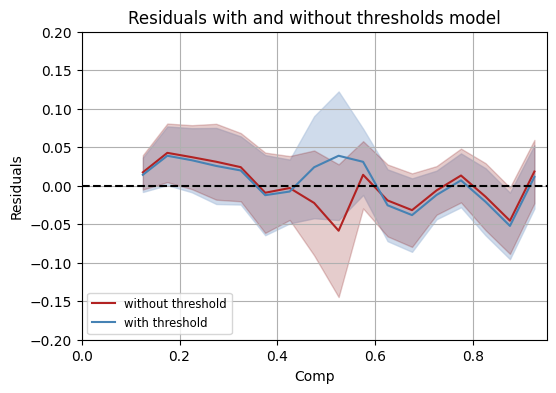

In [80]:
residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0.1, 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(0.0, 0.95)
plt.ylim(-0.2, 0.2)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

In [16]:
x_cols = ['Comp','Agri','IronCav','Comp_sq','Scale_1']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Scale_1'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     4532.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:49:22   Log-Likelihood:                 1339.8
No. Observations:                1161   AIC:                            -2670.
Df Residuals:                    1156   BIC:                            -2644.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Comp           1.0422      0.031     34.068      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_21192\2085515406.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Scale_1'], inplace=True)


(1.0, 9.0)

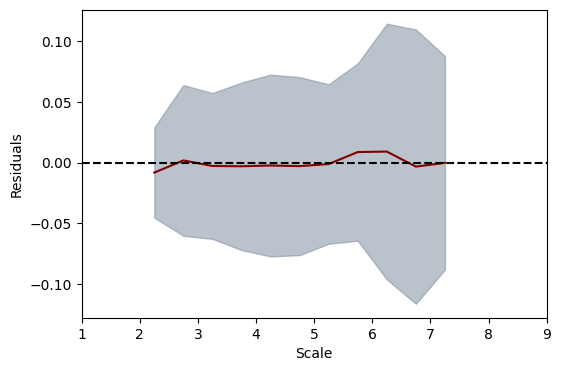

In [17]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)

results = analyze_residuals(scale_values, residuals, bins)
results_before = results.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Scale')
plt.ylabel('Residuals')
plt.xlim(1, 9.)

In [18]:
thresh_start = np.arange(2, 8 , 0.1)
thresh_end = np.arange(6, 10, 0.1)
x_cols = ['Scale_1','Comp_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p','log-likelyhood','minres'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp > thresh_s) & (Xy.Comp < thresh_e)
        X['Scale_1'] = 0
        X.loc[mask, 'Scale_1'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Comp_t'].values - predictions))
        }, ignore_index=True)


C:\Users\matil\AppData\Local\Temp\ipykernel_21192\971872464.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_21192\971872464.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\matil\AppData\Local\Temp\ipykernel_21192\971872464.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
C:\Users\matil\AppData\

In [19]:
thresh_min = results.sort_values('minres', ascending=True)[['thresh_start','thresh_end']].iloc[1].values
print(thresh_min)

mask = (Xy.Scale_1 >= thresh_min[0]) & (Xy.Scale_1 < thresh_min[1])
X['Scale_1'] = 0
X.loc[mask, 'Scale_1'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

[5.9 9.6]
                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     3042.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:49:30   Log-Likelihood:                 1344.4
No. Observations:                1161   AIC:                            -2675.
Df Residuals:                    1154   BIC:                            -2639.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.0111      0.009      1.30

C:\Users\matil\AppData\Local\Temp\ipykernel_21192\2309509417.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0


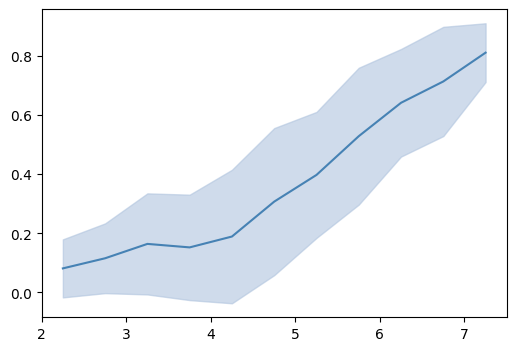

In [20]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)
results = analyze_residuals(scale_values, y['Comp_t'].values, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)


Text(0.5, 1.0, 'Residuals with and without thresholds model')

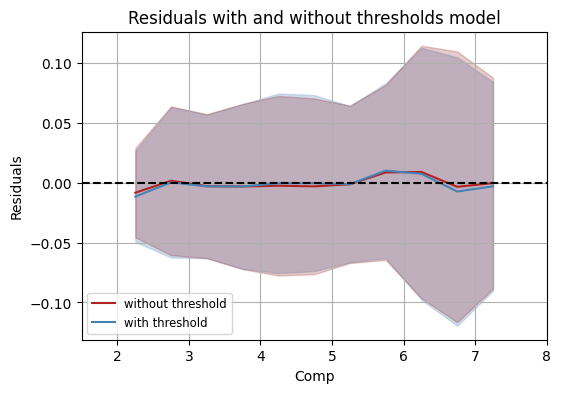

In [21]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)
results = analyze_residuals(scale_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(1.5, 8)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

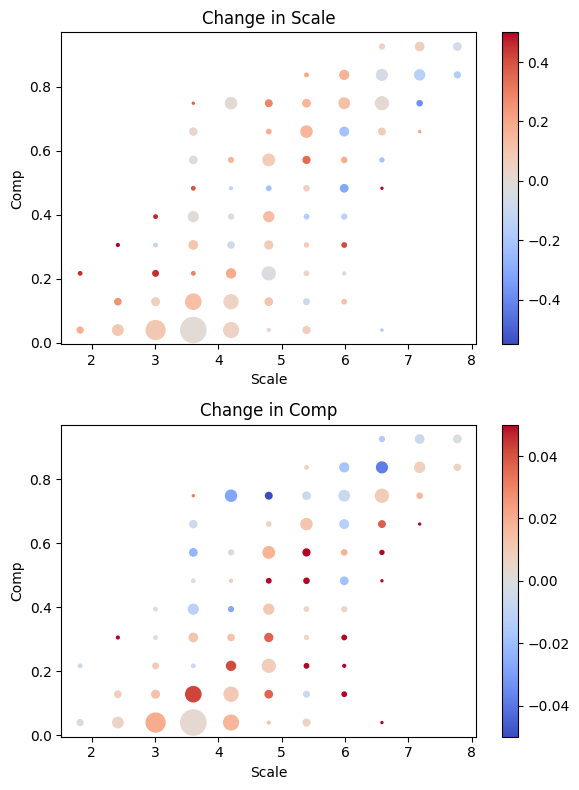

In [22]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

x_cols = ['Scale_1','Comp']
y_col = ['d_Scale','d_Comp']
Xy = dr[y_col+x_cols].dropna()

x = Xy["Scale_1"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std/2 > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std/2 > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*2, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*2, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1731759286.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1731759286.py:14: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


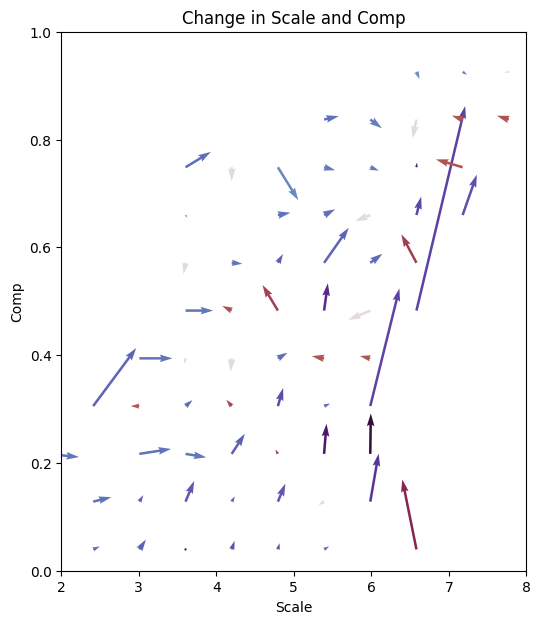

In [23]:
import seaborn as sns


# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 1)
v = np.clip(grid_2.values, -0.1, 0.1)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1355743016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1355743016.py:50: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
C:\Users\matil\AppData\Local\Temp\ipykernel_21192\1355743016.py:51: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


ValueError: Argument U has a size 121 which does not match 144, the number of arrow positions

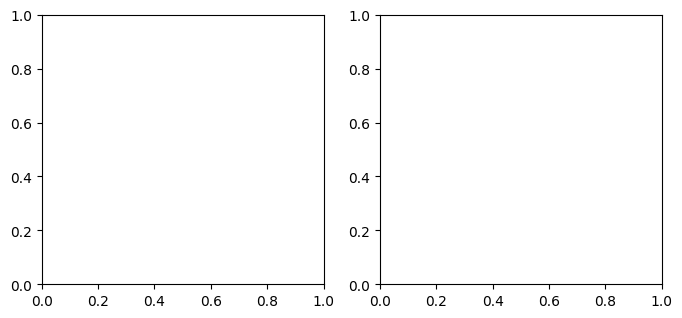

In [24]:
import seaborn as sns

cav = [0, 1, 2]

colors = ['firebrick', 'steelblue', 'darkorange']

fig, ax = plt.subplots(1,2,figsize=(8, 3.5))
cav = [0,1]
# plt.minorticks_on()
for n,c in enumerate(cav):
    Xy = dr.loc[(dr.Cavalry == c)]
    x = Xy["Scale_1"].values
    y = Xy["Comp"].values
    z1 = Xy["d_Scale"].values
    z2 = Xy["d_Comp"].values

    grid_size = 11

    df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

    # Define the grid
    x_bins = np.linspace(min(x), max(x), grid_size + 1)
    y_bins = np.linspace(min(y), max(y), grid_size + 1)

    # Bin the data
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
    grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
    counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

    grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
    grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
    counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

    # create vector plot
    pink_r = plt.cm.get_cmap('pink_r')
    # sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
    u = np.clip(grid_1.values, -1, 1)
    v = np.clip(grid_2.values, -0.1, 0.1)
    u = grid_1.values
    v = grid_2.values

    std_1 = grid_1_std.values/grid_1.values
    std_2 = grid_2_std.values/grid_2.values

    std = np.sqrt(std_1**2 + std_2**2)
    std = np.clip(std, 0, 20)
    t_norm = np.reshape(std, -1)
    t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

    x, y = np.meshgrid(x_bins, y_bins)
    # color arrows according to angle
    color = np.arctan2(v, u)
    color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

    ax[n].quiver(x, y, u, v, scale_units='xy', angles='xy',
            color=color.reshape(-1, 4),
            alpha=1.,  scale=1.1)
    ax[n].set_xlim(1, 8)
    ax[n].set_ylim(0, 1.)
    ax[0].set_ylabel('Comp')
    ax[n].set_title(f'Cavalry: {c}')
    ax[n].grid(True,  alpha=0.5)
    
    ax[n].set_xlabel('Scale')
plt.suptitle('Change in Scale and Comp')
plt.tight_layout()
plt.show()

In [ ]:
changes = pd.DataFrame(columns = ['NGA', 'PolityName', 'Scale', 'Comp', 'd_Scale', 'd_Comp'])

scv_imp_nga = dataset.scv_imputed.groupby('NGA')
for nga, group in scv_imp_nga:
    group = group.sort_values(['Year', 'PolityID'])

    pol_nga = group.groupby('PolityID')
    polities = pol_nga['PolityName'].first()
    scales = pol_nga['Scale_1'].apply(np.mean)
    comps = pol_nga['Comp'].apply(np.mean)
    years = pol_nga['Year'].apply(np.mean)

    d_year = (years.shift(-1)-years)/100
    d_scales = (scales.shift(-1)-scales)/d_year
    d_comps = (comps.shift(-1) - comps)/d_year

    df_temp = pd.DataFrame({'NGA': nga, 'PolityName':polities, 'Scale': scales, 'Comp': comps, 'd_Scale': d_scales, 'd_Comp': d_comps})
    changes = changes.append(df_temp)
changes.dropna(subset = ['d_Scale', 'd_Comp'], inplace = True)

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_te

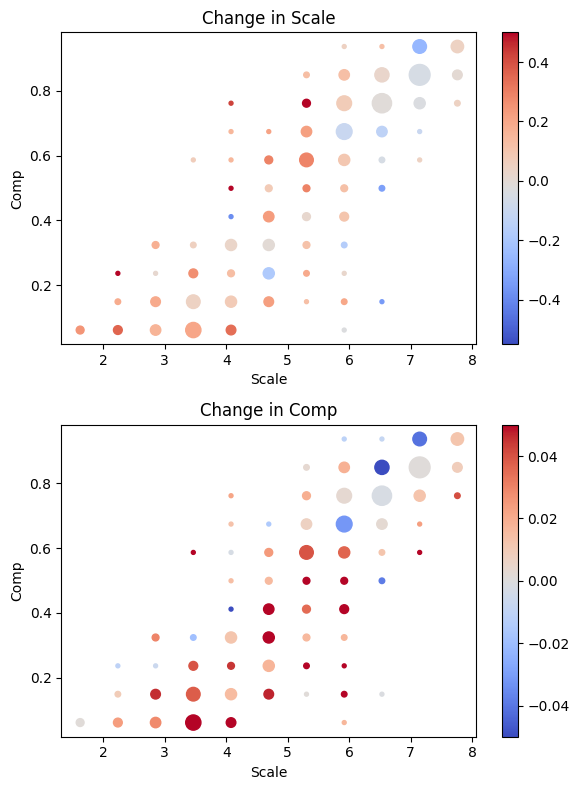

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

Xy = changes

x = Xy["Scale"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*8, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*8, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/1507440410.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')


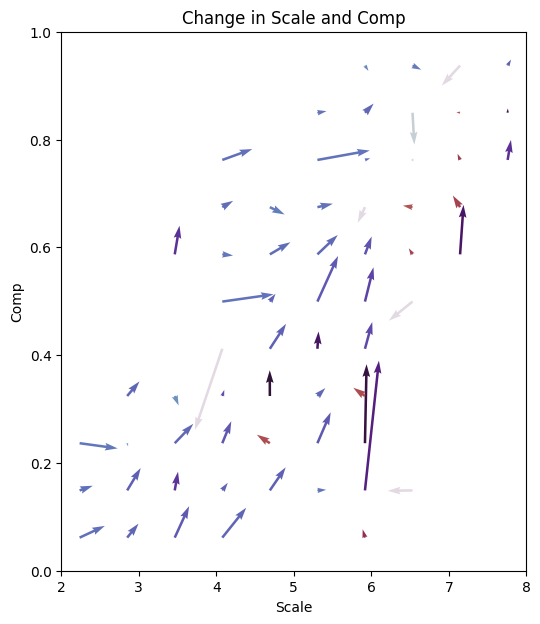

In [ ]:
import seaborn as sns
# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 2)
v = np.clip(grid_2.values, -0.1, 0.2)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()